# Assignment2

## Notebook made by  

|** Name** | **Student id** | **email**|
|: |:-|:-| 
|Brandon Cchung|10800840|bctcchung@gmail.com|
|Sidney de Vries  |10724087 |sidney.de.vries96@gmail.com|

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. 

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='https://cloud.githubusercontent.com/assets/10861155/7042930/cf749982-dde5-11e4-9e8c-4c41080faf55.jpg'/><img src='https://github.com/sidneyd3vries/datascience/blob/master/foto.jpg?raw=true'/>

### Note
* **Assignments without the selfies or completely filled in information will not be graded and receive 0 points.**


# Part 1: obtaining information from the web

### RSS parsing

Make a notebook that performs the following steps.

1. Create a script that retrieves all urls of rss feeds from <http://www.volkskrant.nl/rss/feeds/>. Use urllib2 and beautifulsoup for this. Store the urls in a list.
    * **update 2016**
    * As all Dutch sites, Volkskrant asks whether you accept cookies. This makes simple collecting webpages a lot harder. 
    * The code in the code cell below does the trick. 
    * After running this, I could collect further files from Volkskrant without additional cookie hassle.
2. Download all rss feeds and store them on disk.
3. Parse all RSS feeds using `lxml`. Create a list of  dicts with fields "channel", "url", "title", "date" in which you store this information for each item.
4. Compute some statistics about this dict: how many items, how many per channel, are there doubles (items occuring in several channels), etc.
5. Write this list as a csv file, store on disk, and upload to Google fusion tables.
6. Download all articles (once), parse out the text and store as pairs (date,text) in a list.
7. Count per day the number of words, and the number of unique words. Show this in a plot.

In [1]:
import cookielib # Thanks to http://stackoverflow.com/questions/29395407/enabling-cookies-with-urllib
import urllib2
import urllib
import requests
import os
from bs4 import BeautifulSoup
import re 

url = 'http://www.volkskrant.nl/rss/feeds/'

# with urllib2 and handling cookies
cookiejar= cookielib.LWPCookieJar()
opener= urllib2.build_opener( urllib2.HTTPCookieProcessor(cookiejar) )
response=opener.open(url)
html_doc= ' '.join(response.readlines())
 
rsssoup = BeautifulSoup(html_doc)

#1

list_items = [ref['href'] for ref in rsssoup.find_all('a', href=re.compile('http://www.volkskrant.nl'))]
list_items = [ref for ref in list_items if 'rss.xml' in ref]
list_items[:10]

['http://www.volkskrant.nl/nieuws/rss.xml',
 'http://www.volkskrant.nl/nieuws-voorpagina/rss.xml',
 'http://www.volkskrant.nl/buitenland/rss.xml',
 'http://www.volkskrant.nl/binnenland/rss.xml',
 'http://www.volkskrant.nl/opinie/rss.xml',
 'http://www.volkskrant.nl/economie/rss.xml',
 'http://www.volkskrant.nl/sport/rss.xml',
 'http://www.volkskrant.nl/tech/rss.xml',
 'http://www.volkskrant.nl/media/rss.xml',
 'http://www.volkskrant.nl/wetenschap/rss.xml']

In [2]:
#2

count = 0
for i in list_items:
        count += 1
        filename = "test" + str(count) + ".xml"
        r = requests.get(i)
        with open(filename, "wb") as code:
            code.write(r.content)

In [2]:
#3

from lxml import etree
from lxml import objectify
from itertools import chain

# Now parse it to a tree

count = 0
cool_dicts = []

for i in list_items:
    count += 1
    filename = "test" + str(count) + ".xml"
    with open(filename) as f:
        first_line = f.readline()
        if first_line.startswith("<"):
            parsed = etree.parse(f)
            channel = parsed.xpath('//channel//title')
            url = parsed.xpath('//item//link')
            titles=parsed.xpath('//item//title')
            dates = parsed.xpath('//item//pubDate')
        
            channelstring = [c.text for c in channel if c.text.startswith('VK')]
            titlestrings= [ t.text for t in titles]
            datestrings = [d.text for d in dates]
            urlstrings = [u.text for u in url]
                
            if len(titlestrings) >0:
                for i in range(len(titlestrings)):
                    cool_dicts.append({"Channel":channelstring[0], "Title": titlestrings[i], "Date": datestrings[i], "Url": urlstrings[i]})
cool_dicts[:5]

[{'Channel': 'VK:Voorpagina',
  'Date': 'Thu, 09 Feb 2017 18:30:00 GMT',
  'Title': 'Jongeren in de bres voor project Europa',
  'Url': 'http://www.volkskrant.nl/opinie/jongeren-in-de-bres-voor-project-europa~a4460280/'},
 {'Channel': 'VK:Voorpagina',
  'Date': 'Thu, 09 Feb 2017 18:30:00 GMT',
  'Title': "'Voor mij draait het leven om verliefd zijn'",
  'Url': 'http://www.volkskrant.nl/media/-voor-mij-draait-het-leven-om-verliefd-zijn~a4460241/'},
 {'Channel': 'VK:Voorpagina',
  'Date': 'Thu, 09 Feb 2017 18:30:00 GMT',
  'Title': 'Het grootste restaurant ter wereld heeft geen eten',
  'Url': 'http://www.volkskrant.nl/opinie/het-grootste-restaurant-ter-wereld-heeft-geen-eten~a4460254/'},
 {'Channel': 'VK:Voorpagina',
  'Date': 'Thu, 09 Feb 2017 17:34:00 GMT',
  'Title': "Verkiezingsblog - VVD distantieert zich van uitspraken eigen Kamerlid over 'Eurabia'",
  'Url': 'http://www.volkskrant.nl/politiek/verkiezingsblog-vvd-distantieert-zich-van-uitspraken-eigen-kamerlid-over-eurabia~a444955

In [3]:
#4

from collections import Counter

items = len(cool_dicts)

print items

channels = [l.get('Channel') for l in cool_dicts]
print Counter(channels)

doubles = len([i.get("Url") for i in cool_dicts]) - len(set([i.get("Url") for i in cool_dicts]))
print doubles

1174
Counter({'VK:Voorpagina': 160, 'VK:Festivals': 40, 'VK:Opinie': 40, 'VK:Economie': 40, 'VK:Koken & Eten': 40, 'VK:Beeldende Kunst': 40, 'VK:Film': 40, 'VK:Binnenland': 40, 'VK:Media': 40, 'VK:Buitenland': 40, 'VK:Boeken': 40, 'VK:Foto': 40, 'VK:Wetenschap': 40, 'VK:Archief': 40, 'VK:Voordeel': 40, 'VK:Reizen': 40, 'VK:Magazine': 40, 'VK:Tech': 40, 'VK:Televisie': 40, 'VK:Theater': 40, 'VK:Mode & Mooi': 40, 'VK:Muziek': 40, 'VK:Vonk': 40, 'VK:Politiek': 40, 'VK:Sport': 40, 'VK:Recensies': 40, 'VK:Cartoons': 14})
360


In [5]:
#5

import csv
import pandas as pd

df = pd.DataFrame(cool_dicts)
df.to_csv('test.csv',sep='\t', encoding='utf-8')


In [16]:
#6 Download
count = 0
check = []
for i in cool_dicts:
    count += 1
    filename = "article" + str(count) + ".xml"
    if i['Url'] not in check:
        # Checks for only articles
        if not i['Url'].endswith("play=true"):
            check.append(i['Url'])
            r = requests.get(i['Url'])
            with open(filename, "wb") as code:
                code.write(r.content)
    else:
        None

In [4]:
#6 Parsing 

import os
pairs = []

for filename in os.listdir('.'):
    if filename.endswith(".xml"):
        with open(filename) as f:
            soup = BeautifulSoup(f)
            body = soup.findAll("p", class_=re.compile("article__body__paragraph"))
            date =  soup.find("time", class_="article__publication-date")
            bodytext = " ".join([i.getText() for i in body])
            if date is not None:
                datetext = date.getText()

            pairs.append((datetext, bodytext))
pairs[:1]

[(u'9 februari 2017, 19:30',
  u'Er zijn nog mensen die geloven in Europa. Een heleboel jonge blozende mensen bij elkaar, in een verlaten fabriek in het centrum van de stad, en het eerste wat ik zie is dat ze selfies maken met het Verdrag van Maastricht. Dat bestaat 25 jaar, het is een verjaardagsfeestje. De jonge Europeanen dragen roze hoodies, drinken uit waterflesjes met Yo!Fest EU erop en er loopt een Superman rond met een Europese vlag als cape. Het is even knipperen met mijn ogen. Buiten op straat moet je niet over Europa beginnen, hou toch op meneer. ')]

In [6]:
#7 - Preparation

days = {}

# Samplesize = 100
for i in pairs[:100]:
    day = i[0][:-7]
    words =  len(i[1].split())
    unique_words = len(set(i[1].split()))
    if day not in days:
        days[(str(day))] = [words, unique_words]
    else:
        days[(str(day))][0] += words
        days[(str(day))][1] += unique_words 
print days

{'14 oktober 2016': [81, 66], '9 februari 2017': [394, 291], '30 november 2016': [94, 77], '6 februari 2017': [372, 268], '4 november 2016': [207, 166], '12 november 2016': [557, 319], '13 november 2016': [80, 68], '5 februari 2017': [401, 278], '2 december 2016': [540, 341], '1 februari 2017': [1731, 1116], '15 september 2016': [184, 150], '4 januari 2017': [175, 118], '4 februari 2017': [1980, 1358], '22 oktober 2016': [1201, 661], '10 januari 2017': [68, 52], '31 januari 2017': [783, 504], '28 januari 2017': [1609, 1103], '3 februari 2017': [429, 298], '23 oktober 2016': [1438, 910], '23 januari 2017': [80, 67], '5 december 2016': [104, 82], '21 oktober 2016': [364, 242], '14 november 2016': [0, 0], '27 oktober 2016': [91, 75], '6 januari 2017': [64, 57], '3 november 2016': [105, 91], '7 februari 2017': [104, 83], '22 september 2016': [92, 78], '24 januari 2017': [88, 70], '6 november 2016': [707, 417], '5 september 2016': [78, 63], '15 januari 2017': [542, 346], '12 september 2016'

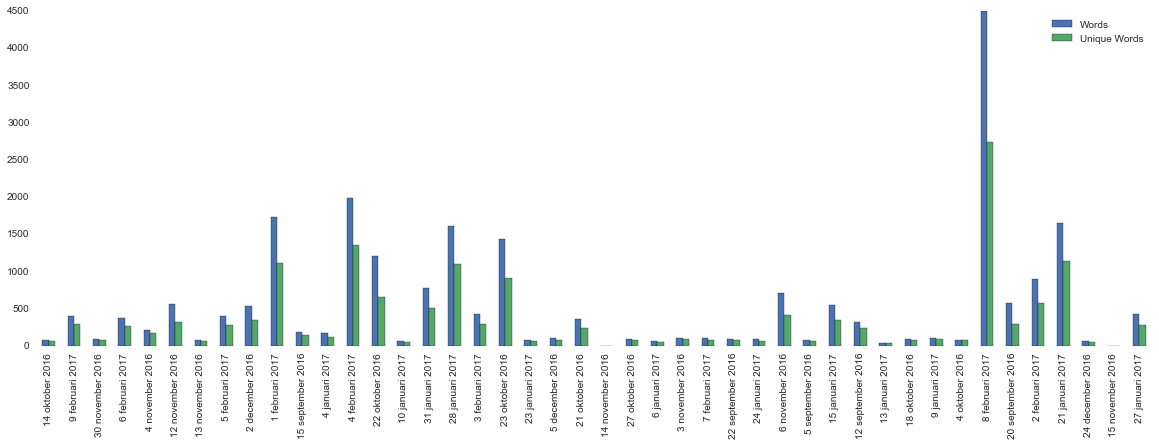

In [20]:
#7 - Plot

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

frame = pd.DataFrame.from_dict(days, orient = 'index')
frame.columns=['Words', 'Unique Words']
frame.plot(figsize=(20, 6), kind='bar')

### JSON parsing

1. Download <http://maartenmarx.nl/teaching/ISatWork/NoteBooks/consuming-json-data-from-a-web-service.ipynb>, remove all code blocks, and turn it into a notebook again. 
2. Check that what you did is correct and you did not remove too much using a notebook viewer.
3. Now extract all code from the downloaded notebook, save it to a file, and execute it as a Python script. Does it give errors? Is it syntactically correct?

In [3]:
import json
url = "http://maartenmarx.nl/teaching/DataScience/NoteBooks/consuming-json-data-from-a-web-service.ipynb"
jsonfile= urllib2.urlopen(url)
json_as_python_object = json.load(jsonfile) # The josnfile transformed into a Python dict

#1 & 2

no_cells = [i for i in json_as_python_object.get('cells') if i.get('cell_type') != 'code']

json_as_python_object['cells'] = no_cells

with open('test.ipynb', 'w') as outfile:
    json.dump(json_as_python_object, outfile)
    
# New notebook has all the code removed and can be run without errors.

In [5]:
#3

import json
url = "http://maartenmarx.nl/teaching/DataScience/NoteBooks/consuming-json-data-from-a-web-service.ipynb"
jsonfile= urllib2.urlopen(url)
json_as_python_object = json.load(jsonfile) # The josnfile transformed into a Python dict

with_cells = [i for i in json_as_python_object.get('cells') if i.get('cell_type') == 'code']

json_as_python_object['cells'] = with_cells

with open('test2.ipynb', 'w') as outfile:
    json.dump(json_as_python_object, outfile)

# All code can be run without erros, except for the function at the end, which was already broken in the first place.

### PDF parsing

1. Save a wordfile as PDF, open it in Python, extract all text. Describe the differences, if any. Try the same with a two column PDF file from the web. This exercise gets more interesting if you use _difficult_ PDF. Why not try <http://wch.github.io/latexsheet/latexsheet.pdf>?

* Is the word order still as it should be?
* What about the strange characters?

In [8]:
#1 - Output single column

from PyPDF2 import PdfFileWriter, PdfFileReader

input1 = PdfFileReader(open("FEB.pdf", "rb"))

num_of_pages = input1.getNumPages()

for i in range(0 , num_of_pages ):  
        pageObj = input1.getPage(i)
        page = pageObj.extractText()
        #print page

# Example
sample = input1.getPage(2)
output = sample.extractText()
print output[:200]

3
 
Inleiding
 
 
De vliegtuigmaatschappij KLM (Koninklijke Luchtvaart Maatschappij) staat bekend om haar goede 
reputatie
,
 
door
 
onder andere
 
het feilloos leveren van vluchtdiensten
 
zowel bin


In [17]:
#1 - Output multiple columns

input1 = PdfFileReader(open("latexsheet.pdf", "rb"))

num_of_pages = input1.getNumPages()

for i in range(0 , num_of_pages ):  
        pageObj = input1.getPage(i)
        page = pageObj.extractText()
        #print page

# Example
sample = input1.getPage(0)
output = sample.extractText()
print output[200:400]

ofadocument:
\documentclass{
class
}
.Use
\begin{document}
tostart
contentsand
\end{document}
toendthedocument.
Common
documentclass
options
10pt
/
11pt
/
12pt
Fontsize.
letterpaper
/
a4paper
Papersiz


#1, 2 & 3

Text extraction explanation:

For a pdf with a single column: the difference is mostly in the (excessive) amount of spacing and line breaks, which is logical as these are also prevalent in the original PDF itself but with styling. Each bracket does tend to create a new line though. The word order, however is completely the same as the original and strange characters are handled perfectly.

For a pdf with more columns: the text becomes incoherent and unreadable, with a lot of code and markup language jammed in as well. There is also no useful spacing and textlines are near exclusively just singular words. The word order seems to be somewhat in tact and all strange characters such as math-mode symbols are represented by their code variant. 





# Part 2  Monty Hall

# Q1 (Monty Hall problem)

In [23]:
import numpy as np
import random

def simulate_prizedoor(nsim, n):
    answer = [np.random.randint(0,n) for i in range(nsim)]
    return answer

print simulate_prizedoor(3, 3)

[1, 0, 0]


In [24]:
def simulate_guess(nsim, n):
    guess = np.random.randint(0,n)
    answer = [guess for i in range(nsim)]
    return answer

print simulate_guess(3, 3)

[1, 1, 1]


In [25]:
def win_percentage(guesses, prizedoors):
    percentage = []
    for i in range(len(guesses)):
        if guesses[i] == prizedoors[i]:
            percentage.append(1)
        else:
            percentage.append(0)
    return (float((sum(percentage))) / float(len(percentage))) * 100

In [26]:
def monty(nsim, n):
    prizedoor = simulate_prizedoor(nsim, n)
    guesses = simulate_guess(nsim, n)
    goat = []
    switch = []
    
    for i in range(len(prizedoor)):
        answers = [x for x in range(n)]
        # Goat Door
        if prizedoor[i] != guesses[i]:
            answers.remove(prizedoor[i])
            answers.remove(guesses[i])
            goat.append(np.random.choice(answers))
            
        else:
            answers.remove(prizedoor[i])
            goat.append(np.random.choice(answers))
            
    for i in range(len(prizedoor)):
        # Switch
        answers = [x for x in range(n)]
        if guesses[i] != goat[i]:
            answers.remove(goat[i])
            answers.remove(guesses[i])
            switch.append(np.random.choice(answers))
        else:
            answers.remove(guesses[i])
            switch.append(np.random.choice(answers))
    print "Original Guess:", win_percentage(guesses, prizedoor)
    print "Switch Guess:", win_percentage(switch, prizedoor)
           
        
monty(10000, 3)

Original Guess: 33.39
Switch Guess: 66.61


##  This counts for your mark

Generalize your simulation code to handle the case of `n` doors.


This sentence can be read in two ways, giving very different outcomes! You must program both, and understand that it all makes sense.


### Your work
For both interpretations, give a plot with the number of doors on the x-axis and the win_percentage on the y-axis, and plot that value for the two strategies for numbers of doors between 3 and 20. 

Describe briefly what is going on here, and why the plots makes sense.


### Interpretation  1
* There are _n_ doors.
* You have chosen one door.
* The host opens one door as before (it is not the door you have chosen and not a door with the prize)
* Now you switch or not.

In [27]:
def monty1(nsim, n):
    prizedoor = simulate_prizedoor(nsim, n)
    guesses = simulate_guess(nsim, n)
    goat = []
    switch = []
    
    for i in range(len(prizedoor)):
        answers = [x for x in range(n)]
        # Goat Door
        if prizedoor[i] != guesses[i]:
            answers.remove(prizedoor[i])
            answers.remove(guesses[i])
            goat.append(np.random.choice(answers))
            
        else:
            answers.remove(prizedoor[i])
            goat.append(np.random.choice(answers))
            
    for i in range(len(prizedoor)):
        # Switch
        answers = [x for x in range(n)]
        if guesses[i] != goat[i]:
            answers.remove(goat[i])
            answers.remove(guesses[i])
            switch.append(np.random.choice(answers))
        else:
            answers.remove(guesses[i])
            switch.append(np.random.choice(answers))
            
    #Returns winpercentage for always sticking with a choice, and the winpercentage for always switching.
    return (win_percentage(guesses, prizedoor), win_percentage(switch, prizedoor))

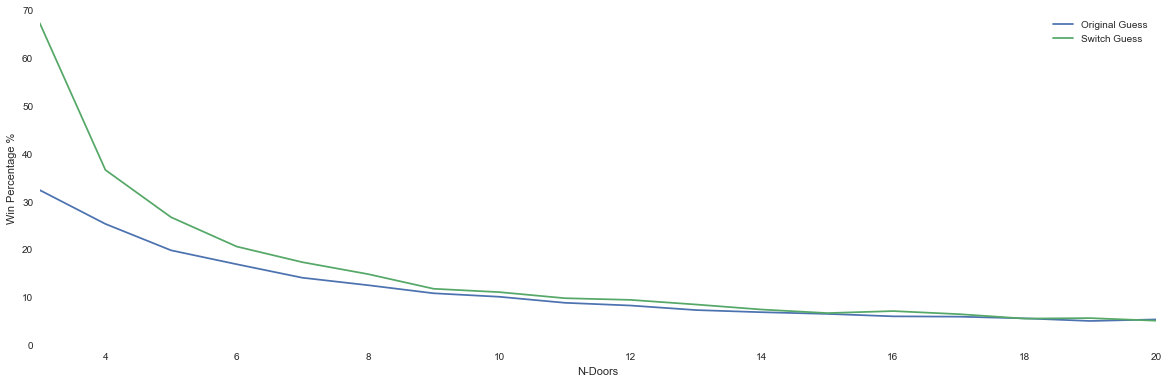

In [32]:
# Plot Monty interpretation 1

array1 = [monty1(10000, i) for i in range(3,21)]
for i in range(3):
    array1.insert(0, (0,0))
    
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

frame = pd.DataFrame(array1, columns=['Original Guess', 'Switch Guess'])
ax = frame.plot(figsize=(20, 6))
ax.set_xlim(3,20)
ax.set_xlabel("N-Doors")
ax.set_ylabel("Win Percentage %")

### Interpretation 2
* There are _n_ doors.
* You have chosen one door.
* The host opens _all except two doors_, namely your door, and a random other door.  Behind none of the opened doors lies the prize.

In [29]:
def monty2(nsim, n):
    prizedoor = simulate_prizedoor(nsim, n) 
    guesses = simulate_guess(nsim, n)  
    other_door = [] 
    switch = []
    
    for i in range(len(prizedoor)):
        answers = [x for x in range(n)]
        # Goat Doors
        if prizedoor[i] != guesses[i]:
            answers.remove(prizedoor[i])
            answers.remove(guesses[i])
            other_door.append(np.random.choice(answers))
        else:
            answers.remove(prizedoor[i])
            other_door.append(np.random.choice(answers))  
               
    for i in range(len(prizedoor)):
        # Switch
        if guesses[i] != prizedoor[i]:
            switch.append(prizedoor[i])
        else:
            switch.append(other_door[i]) 
            
    return (win_percentage(guesses, prizedoor), win_percentage(switch, prizedoor))

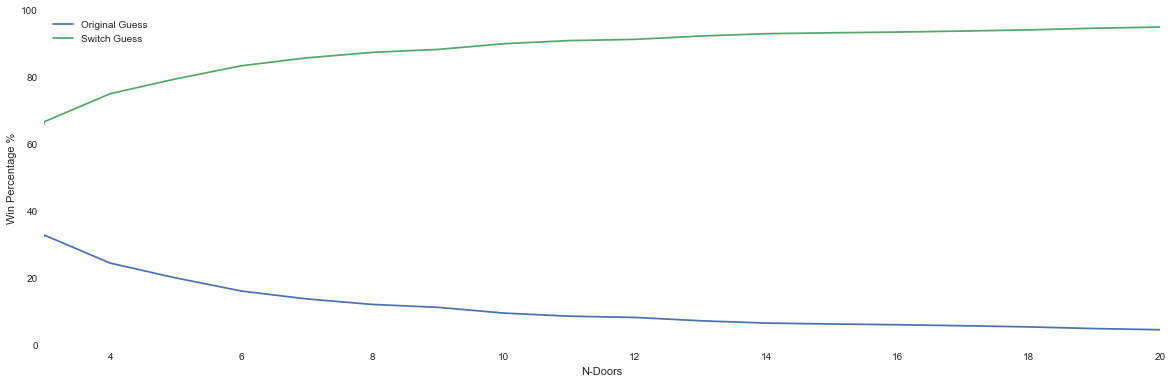

In [31]:
# Plot Monty interpretation 2

array2 = [monty2(10000, i) for i in range(3,21)]
for i in range(3):
    array2.insert(0, (0,0))

%matplotlib inline

frame = pd.DataFrame(array2, columns=['Original Guess', 'Switch Guess'])
ax = frame.plot(figsize=(20, 6))
ax.set_xlim(3,20)
ax.set_xlabel("N-Doors")
ax.set_ylabel("Win Percentage %")

# Uitleg 

* For the first interpretation, the plot makes sense because while switching doors fetches a higher win percentage, especially with 3 doors, it becomes much less significant when the overall win chance becomes low (such is the case when there are 20 doors and switching to another random door doesn't do that much).

* For the second interpretation, the plot makes sense because if you look at it from a grand perspective, if you normally have a 1/20 chance to win with 20 doors and all the doors get revealed but yours and a random other door (with the prizedoor being behind yours of the other door), your chance will still remain 1/20 if you stay there because in terms of your win chance nothing changed. But it actually becomes 19/20 if you switch to the other door.